# 전략 실험 노트북 (Strategy Experiments)

이 노트북은 다양한 전략 파라미터와 설정을 실험하고 결과를 비교 분석하기 위한 것입니다.

## 실험 목적
- 전략 파라미터 최적화
- 다양한 필터/조건 조합 테스트
- 성능 메트릭 비교 분석
- 실험 결과 추적 및 저장

## 실험 기록
각 실험마다 다음 정보를 기록합니다:
- 실험 ID 및 날짜
- 전략 파라미터
- 백테스트 결과
- 주요 메트릭
- 비고 및 인사이트

In [1]:
# Setup and imports
import json
import sys
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from src.backtester import BacktestConfig, generate_report, run_backtest
from src.config import REPORTS_DIR
from src.strategies.volatility_breakout import VanillaVBO, create_vbo_strategy
from src.strategies.volatility_breakout.conditions import (
    NoiseThresholdFilter,
    VolatilityThresholdCondition,
)
from src.utils.logger import setup_logging

# Setup logging
setup_logging()

# Ensure directories exist
REPORTS_DIR.mkdir(exist_ok=True)
experiments_dir = project_root / "notebooks" / "experiments"
experiments_dir.mkdir(exist_ok=True)

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"📁 Experiments directory: {experiments_dir}")

✅ Setup complete!
📁 Experiments directory: C:\workspace\dev\upbit-quant-system\notebooks\experiments


In [2]:
# 실험 결과 저장을 위한 헬퍼 함수


def is_condition_object(obj) -> bool:
    """Check if object is a Condition instance by checking for evaluate method."""
    # Check if it has the required attributes of a Condition
    if not (hasattr(obj, "evaluate") and hasattr(obj, "name")):
        return False

    # Verify evaluate is callable
    if not callable(getattr(obj, "evaluate", None)):
        return False

    # Additional check: Condition objects typically have __class__ and are not basic types
    return not isinstance(obj, (int, float, str, bool, type(None), dict, list, tuple))


def serialize_condition(condition) -> dict:
    """Convert condition object to JSON-serializable dict."""
    # Get condition class name
    condition_dict = {
        "class": condition.__class__.__name__,
        "name": getattr(condition, "name", condition.__class__.__name__),
    }

    # Extract constructor parameters based on condition type
    if hasattr(condition, "min_range_pct"):
        condition_dict["min_range_pct"] = condition.min_range_pct
    if hasattr(condition, "max_noise"):
        condition_dict["max_noise"] = condition.max_noise
    if hasattr(condition, "noise_key"):
        condition_dict["noise_key"] = condition.noise_key
    if hasattr(condition, "min_volatility_pct"):
        condition_dict["min_volatility_pct"] = condition.min_volatility_pct
    if hasattr(condition, "max_volatility_pct"):
        condition_dict["max_volatility_pct"] = condition.max_volatility_pct
    if hasattr(condition, "days"):
        condition_dict["days"] = condition.days

    return condition_dict


class ConditionEncoder(json.JSONEncoder):
    """Custom JSON encoder that handles Condition objects."""

    def default(self, obj):
        if is_condition_object(obj):
            return serialize_condition(obj)
        # Try the default serialization
        try:
            return super().default(obj)
        except TypeError:
            # Fallback to string representation
            return str(obj)


def make_json_serializable(obj):
    """Recursively convert objects to JSON-serializable format."""
    # Handle None first
    if obj is None:
        return None

    # Handle basic types
    if isinstance(obj, (int, float, str, bool)):
        return obj

    # Handle dicts - recursively process all values
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}

    # Handle lists/tuples - recursively process all items
    if isinstance(obj, (list, tuple)):
        return [make_json_serializable(item) for item in obj]

    # Handle condition objects
    if is_condition_object(obj):
        return serialize_condition(obj)

    # For other objects, try to convert to string
    # This handles any remaining non-serializable objects
    try:
        return str(obj)
    except Exception:
        return f"<non-serializable: {type(obj).__name__}>"


class ExperimentTracker:
    """실험 결과를 추적하고 저장하는 클래스"""

    def __init__(self, experiments_dir: Path):
        self.experiments_dir = experiments_dir
        self.experiments = []
        self.experiment_id = 0

    def save_experiment(
        self,
        name: str,
        strategy_params: dict,
        config_params: dict,
        result,
        notes: str = "",
    ) -> dict:
        """실험 결과를 저장하고 반환"""
        self.experiment_id += 1
        timestamp = datetime.now().isoformat()

        # Serialize strategy_params to handle condition objects
        serialized_strategy_params = make_json_serializable(strategy_params)

        experiment = {
            "id": self.experiment_id,
            "name": name,
            "timestamp": timestamp,
            "strategy_params": serialized_strategy_params,
            "config_params": make_json_serializable(config_params),
            "results": {
                "cagr": float(result.cagr),
                "mdd": float(result.mdd),
                "sharpe_ratio": float(result.sharpe_ratio),
                "calmar_ratio": float(result.calmar_ratio),
                "win_rate": float(result.win_rate),
                "total_trades": int(result.total_trades),
                "total_return": float(result.total_return),
                "profit_factor": float(result.profit_factor),
            },
            "notes": notes,
        }

        self.experiments.append(experiment)

        # Save to JSON
        json_path = self.experiments_dir / f"experiment_{self.experiment_id:03d}_{name}.json"
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(experiment, f, indent=2, ensure_ascii=False, cls=ConditionEncoder)

        print(f"💾 Experiment saved: {json_path.name}")
        return experiment

    def get_comparison_df(self) -> pd.DataFrame:
        """모든 실험 결과를 DataFrame으로 반환"""
        if not self.experiments:
            return pd.DataFrame()

        rows = []
        for exp in self.experiments:
            row = {
                "ID": exp["id"],
                "Name": exp["name"],
                "CAGR": exp["results"]["cagr"],
                "MDD": exp["results"]["mdd"],
                "Sharpe": exp["results"]["sharpe_ratio"],
                "Calmar": exp["results"]["calmar_ratio"],
                "Win Rate": exp["results"]["win_rate"],
                "Trades": exp["results"]["total_trades"],
                "Total Return": exp["results"]["total_return"],
            }
            rows.append(row)

        return pd.DataFrame(rows)

    def plot_comparison(self, metrics: list[str] = None):
        """실험 결과 비교 시각화"""
        if not self.experiments:
            print("No experiments to compare")
            return

        df = self.get_comparison_df()
        if metrics is None:
            metrics = ["CAGR", "MDD", "Sharpe", "Calmar", "Win Rate"]

        fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 4 * len(metrics)))
        if len(metrics) == 1:
            axes = [axes]

        for ax, metric in zip(axes, metrics, strict=False):
            df.plot(x="Name", y=metric, kind="bar", ax=ax, legend=False)
            ax.set_title(f"{metric} Comparison", fontsize=14, fontweight="bold")
            ax.set_ylabel(metric)
            ax.tick_params(axis="x", rotation=45)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(
            self.experiments_dir / "experiment_comparison.png", dpi=150, bbox_inches="tight"
        )
        plt.show()


# Initialize tracker
tracker = ExperimentTracker(experiments_dir)
print("📊 Experiment tracker initialized")

📊 Experiment tracker initialized


## 실험 1: 기본 파라미터 조합 테스트

SMA period, trend SMA period, noise period 등의 기본 파라미터를 변경하며 성능을 비교합니다.

In [3]:
# 실험 1: 기본 파라미터 조합

tickers = ["KRW-BTC", "KRW-ETH", "KRW-XRP", "KRW-TRX"]
base_config = BacktestConfig(
    initial_capital=1.0,
    fee_rate=0.0005,
    slippage_rate=0.0005,
    max_slots=4,
)

# 파라미터 조합 실험
param_combinations = [
    {
        "sma_period": 4,
        "trend_sma_period": 8,
        "short_noise_period": 4,
        "long_noise_period": 8,
        "name": "Default",
    },
    {
        "sma_period": 5,
        "trend_sma_period": 10,
        "short_noise_period": 5,
        "long_noise_period": 10,
        "name": "Legacy",
    },
    {
        "sma_period": 3,
        "trend_sma_period": 6,
        "short_noise_period": 3,
        "long_noise_period": 6,
        "name": "Short",
    },
    {
        "sma_period": 6,
        "trend_sma_period": 12,
        "short_noise_period": 6,
        "long_noise_period": 12,
        "name": "Long",
    },
]

print("🔬 Running parameter experiments...\n")

for params in param_combinations:
    name = params.pop("name")
    strategy = VanillaVBO(name=f"VBO_{name}", **params)

    result = run_backtest(
        strategy=strategy,
        tickers=tickers,
        interval="day",
        config=base_config,
    )

    tracker.save_experiment(
        name=f"Exp1_{name}",
        strategy_params=params,
        config_params=base_config.__dict__,
        result=result,
        notes=f"Parameter experiment: {name}",
    )

    print(
        f"✅ {name}: CAGR={result.cagr:.2f}%, MDD={result.mdd:.2f}%, Sharpe={result.sharpe_ratio:.2f}"
    )

print("\n📊 Experiment 1 complete!")

🔬 Running parameter experiments...

💾 Experiment saved: experiment_001_Exp1_Default.json
✅ Default: CAGR=65.23%, MDD=24.85%, Sharpe=1.66
💾 Experiment saved: experiment_002_Exp1_Legacy.json
✅ Legacy: CAGR=96.33%, MDD=21.22%, Sharpe=2.03
💾 Experiment saved: experiment_003_Exp1_Short.json
✅ Short: CAGR=39.93%, MDD=58.00%, Sharpe=1.24
💾 Experiment saved: experiment_004_Exp1_Long.json
✅ Long: CAGR=100.44%, MDD=27.36%, Sharpe=2.03

📊 Experiment 1 complete!


## 실험 2: 필터 조합 테스트

Trend filter와 Noise filter의 다양한 조합을 테스트합니다.

In [4]:
# 실험 2: 필터 조합 테스트

filter_combinations = [
    {"use_trend_filter": True, "use_noise_filter": True, "name": "BothFilters"},
    {"use_trend_filter": True, "use_noise_filter": False, "name": "TrendOnly"},
    {"use_trend_filter": False, "use_noise_filter": True, "name": "NoiseOnly"},
    {"use_trend_filter": False, "use_noise_filter": False, "name": "NoFilters"},
]

print("🔬 Running filter combination experiments...\n")

for filters in filter_combinations:
    name = filters.pop("name")
    strategy = create_vbo_strategy(name=f"VBO_{name}", **filters)

    result = run_backtest(
        strategy=strategy,
        tickers=tickers,
        interval="day",
        config=base_config,
    )

    tracker.save_experiment(
        name=f"Exp2_{name}",
        strategy_params=filters,
        config_params=base_config.__dict__,
        result=result,
        notes=f"Filter combination: {name}",
    )

    print(
        f"✅ {name}: CAGR={result.cagr:.2f}%, MDD={result.mdd:.2f}%, Trades={result.total_trades}"
    )

print("\n📊 Experiment 2 complete!")

🔬 Running filter combination experiments...

💾 Experiment saved: experiment_005_Exp2_BothFilters.json
✅ BothFilters: CAGR=65.23%, MDD=24.85%, Trades=846
💾 Experiment saved: experiment_006_Exp2_TrendOnly.json
✅ TrendOnly: CAGR=37.99%, MDD=62.91%, Trades=1447
💾 Experiment saved: experiment_007_Exp2_NoiseOnly.json
✅ NoiseOnly: CAGR=58.16%, MDD=33.89%, Trades=1088
💾 Experiment saved: experiment_008_Exp2_NoFilters.json
✅ NoFilters: CAGR=18.98%, MDD=75.38%, Trades=1898

📊 Experiment 2 complete!


## 실험 3: 추가 조건 및 필터 테스트

Volatility threshold, Noise threshold 등의 추가 조건을 테스트합니다.

In [5]:
# 실험 3: 추가 조건 및 필터

extra_conditions_experiments = [
    {
        "name": "VolatilityThreshold",
        "extra_entry_conditions": [VolatilityThresholdCondition(min_range_pct=0.01)],
    },
    {
        "name": "NoiseThreshold",
        "extra_entry_conditions": [NoiseThresholdFilter(max_noise=0.65)],
    },
    {
        "name": "BothExtra",
        "extra_entry_conditions": [
            VolatilityThresholdCondition(min_range_pct=0.01),
            NoiseThresholdFilter(max_noise=0.65),
        ],
    },
]

print("🔬 Running extra conditions experiments...\n")

for exp in extra_conditions_experiments:
    name = exp.pop("name")
    strategy = create_vbo_strategy(
        name=f"VBO_{name}",
        use_trend_filter=True,
        use_noise_filter=True,
        **exp,
    )

    result = run_backtest(
        strategy=strategy,
        tickers=tickers,
        interval="day",
        config=base_config,
    )

    tracker.save_experiment(
        name=f"Exp3_{name}",
        strategy_params=exp,
        config_params=base_config.__dict__,
        result=result,
        notes=f"Extra conditions: {name}",
    )

    print(
        f"✅ {name}: CAGR={result.cagr:.2f}%, MDD={result.mdd:.2f}%, Sharpe={result.sharpe_ratio:.2f}"
    )

print("\n📊 Experiment 3 complete!")

🔬 Running extra conditions experiments...

💾 Experiment saved: experiment_009_Exp3_VolatilityThreshold.json
✅ VolatilityThreshold: CAGR=65.17%, MDD=24.23%, Sharpe=1.66
💾 Experiment saved: experiment_010_Exp3_NoiseThreshold.json
✅ NoiseThreshold: CAGR=67.21%, MDD=20.99%, Sharpe=1.72
💾 Experiment saved: experiment_011_Exp3_BothExtra.json
✅ BothExtra: CAGR=67.18%, MDD=20.62%, Sharpe=1.73

📊 Experiment 3 complete!


## 실험 결과 비교 및 시각화

모든 실험 결과를 비교하고 시각화합니다.

In [6]:
# 실험 결과 비교 테이블
comparison_df = tracker.get_comparison_df()

if not comparison_df.empty:
    print("📊 Experiment Comparison Table")
    print("=" * 100)
    print(comparison_df.to_string(index=False))
    print("=" * 100)

    # CSV로 저장
    csv_path = experiments_dir / "experiment_comparison.csv"
    comparison_df.to_csv(csv_path, index=False)
    print(f"\n💾 Comparison table saved: {csv_path}")
else:
    print("No experiments to compare")

📊 Experiment Comparison Table
 ID                     Name       CAGR       MDD   Sharpe   Calmar  Win Rate  Trades  Total Return
  1             Exp1_Default  65.226514 24.852682 1.661933 2.624526 37.588652     846   6273.614593
  2              Exp1_Legacy  96.328009 21.215454 2.034756 4.540464 38.617886     738  26404.799090
  3               Exp1_Short  39.927410 58.003855 1.242757 0.688358 33.833834     999   1512.855546
  4                Exp1_Long 100.437499 27.363329 2.027252 3.670515 38.577912     661  31298.658306
  5         Exp2_BothFilters  65.226514 24.852682 1.661933 2.624526 37.588652     846   6273.614593
  6           Exp2_TrendOnly  37.985416 62.909120 1.001129 0.603814 29.440221    1447   1335.410016
  7           Exp2_NoiseOnly  58.158961 33.885922 1.459896 1.716316 34.466912    1088   4339.117807
  8           Exp2_NoFilters  18.977753 75.378413 0.616370 0.251766 26.765016    1898    321.115906
  9 Exp3_VolatilityThreshold  65.167729 24.226196 1.661978 2.689970 38

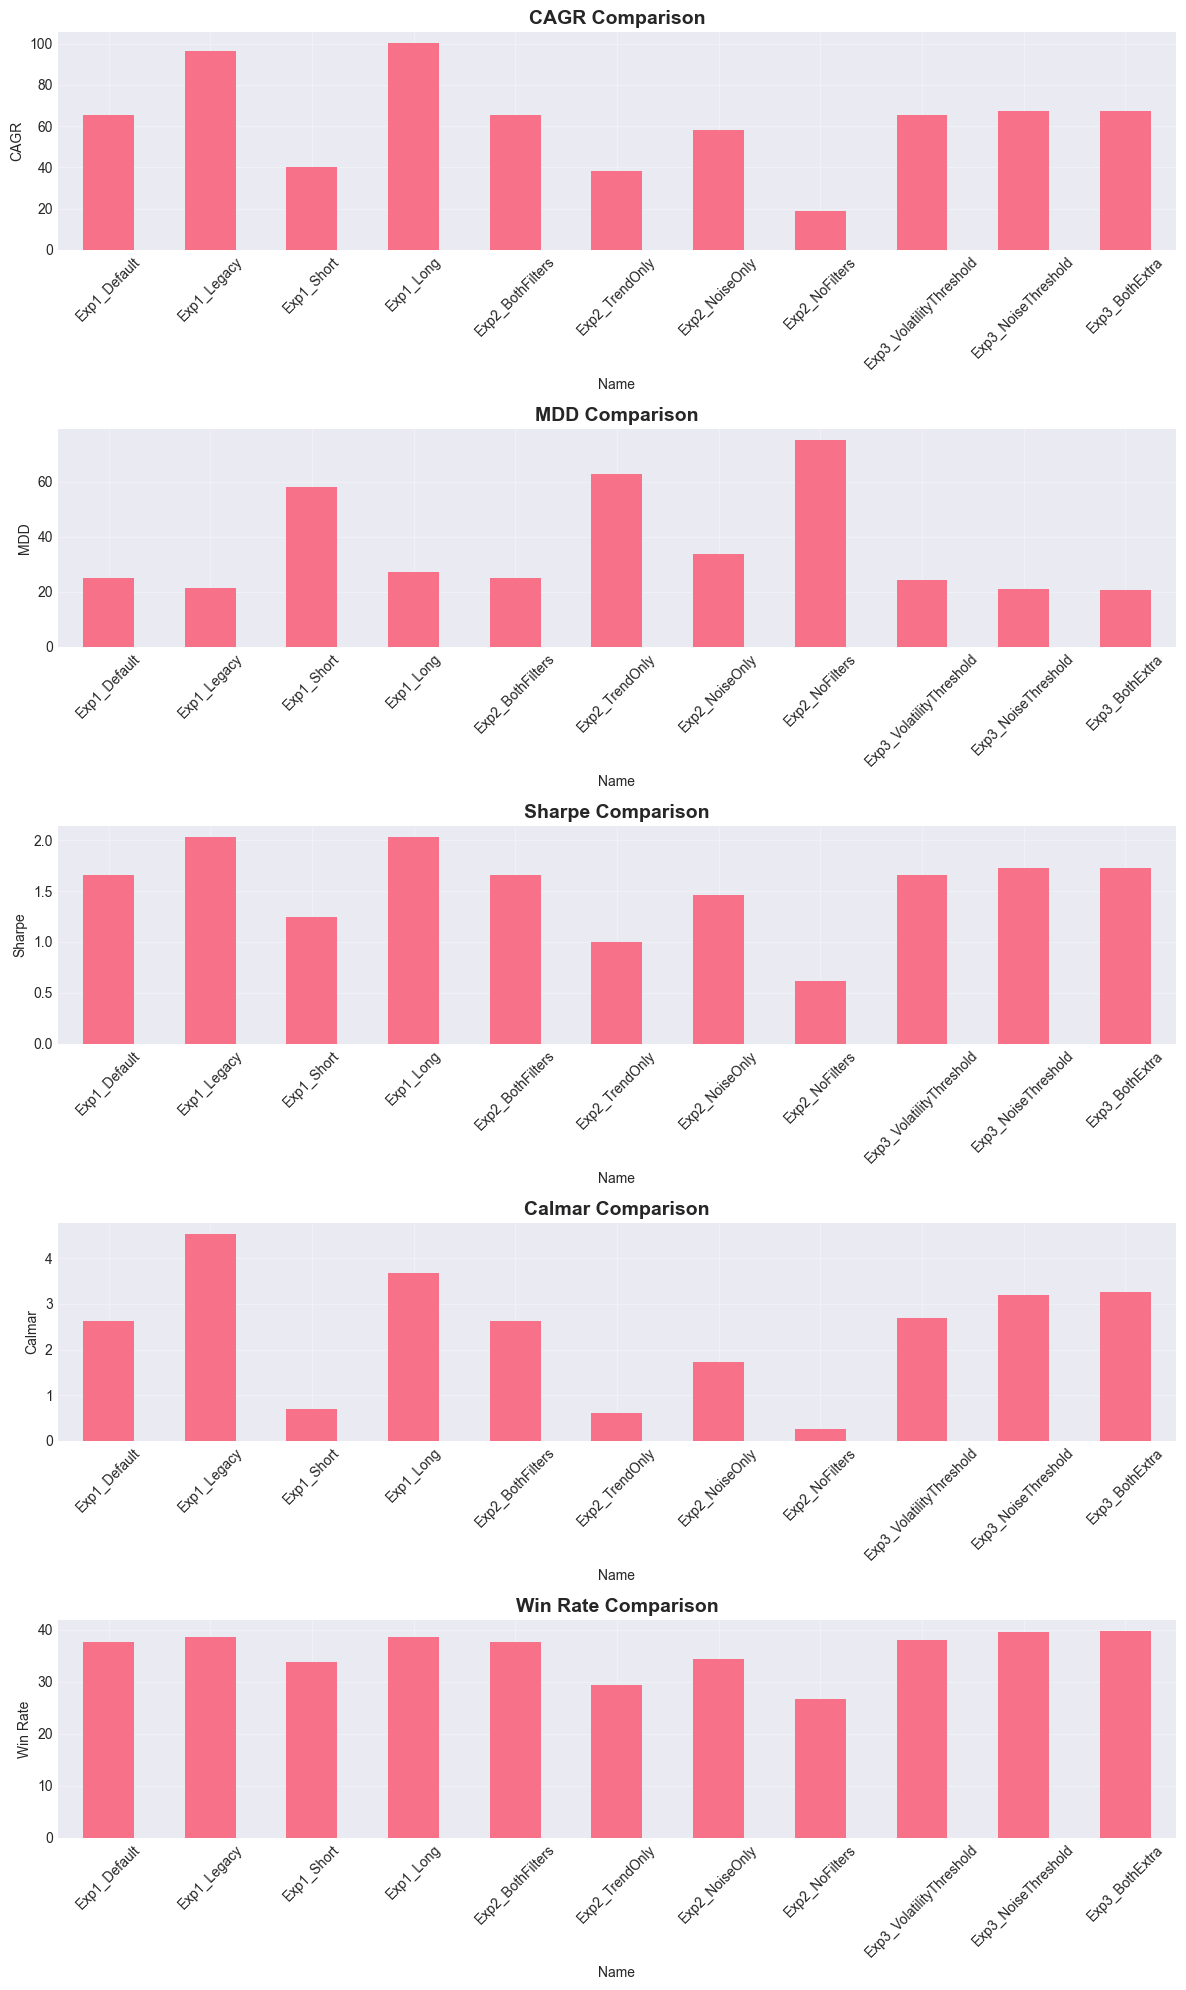

In [7]:
# 실험 결과 시각화
tracker.plot_comparison(metrics=["CAGR", "MDD", "Sharpe", "Calmar", "Win Rate"])

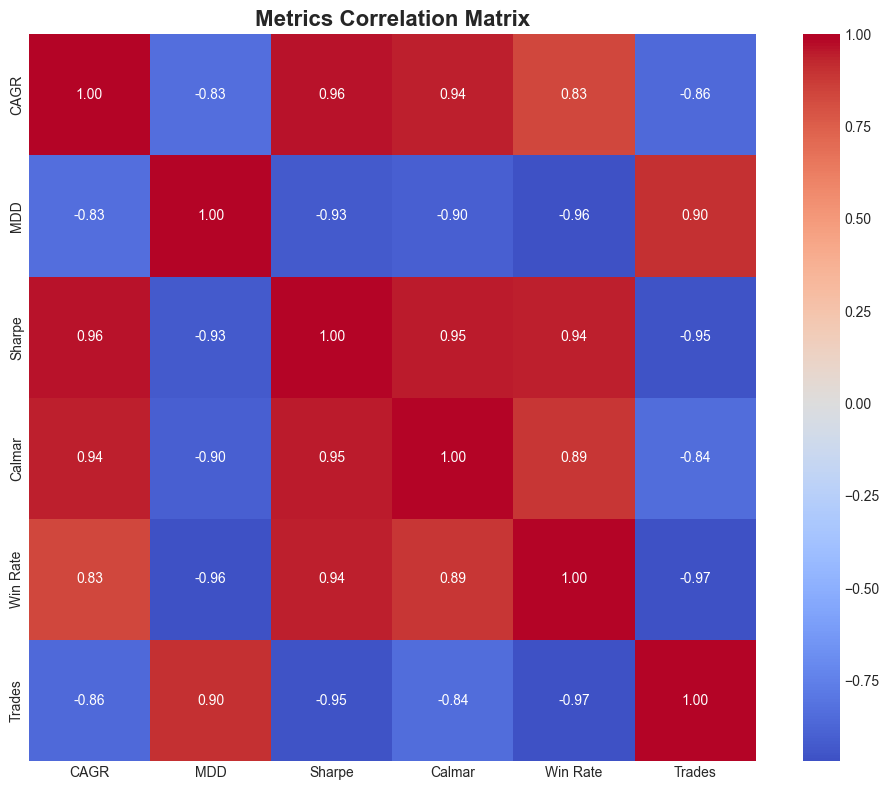

📈 Correlation analysis saved


In [8]:
# 상관관계 분석
if not comparison_df.empty:
    metrics_cols = ["CAGR", "MDD", "Sharpe", "Calmar", "Win Rate", "Trades"]
    corr_matrix = comparison_df[metrics_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
    plt.title("Metrics Correlation Matrix", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.savefig(experiments_dir / "metrics_correlation.png", dpi=150, bbox_inches="tight")
    plt.show()

    print("📈 Correlation analysis saved")

## 최적 전략 선택 및 상세 분석

가장 좋은 성능을 보인 전략을 선택하고 상세 리포트를 생성합니다.

🏆 Best Strategy (by Calmar Ratio)
Name: Exp1_Legacy
CAGR: 96.33%
MDD: 21.22%
Sharpe: 2.03
Calmar: 4.54
Win Rate: 38.62%
Total Trades: 738
2026-01-05 21:11:56 - src.backtester.report - INFO - 
2026-01-05 21:11:56 - src.backtester.report - INFO -   BACKTEST REPORT: Exp1_Legacy
2026-01-05 21:11:56 - src.backtester.report - INFO - ============================================================
2026-01-05 21:11:56 - src.backtester.report - INFO - 
[Period]
2026-01-05 21:11:56 - src.backtester.report - INFO -    Start Date:     2017-09-29
2026-01-05 21:11:56 - src.backtester.report - INFO -    End Date:       2026-01-04
2026-01-05 21:11:56 - src.backtester.report - INFO -    Total Days:     3,019
2026-01-05 21:11:56 - src.backtester.report - INFO - 
[Returns]
2026-01-05 21:11:56 - src.backtester.report - INFO -    Total Return:   26,404.80%
2026-01-05 21:11:56 - src.backtester.report - INFO -    CAGR:           96.33%
2026-01-05 21:11:56 - src.backtester.report - INFO - 
[Risk]
2026-01-05 21:11

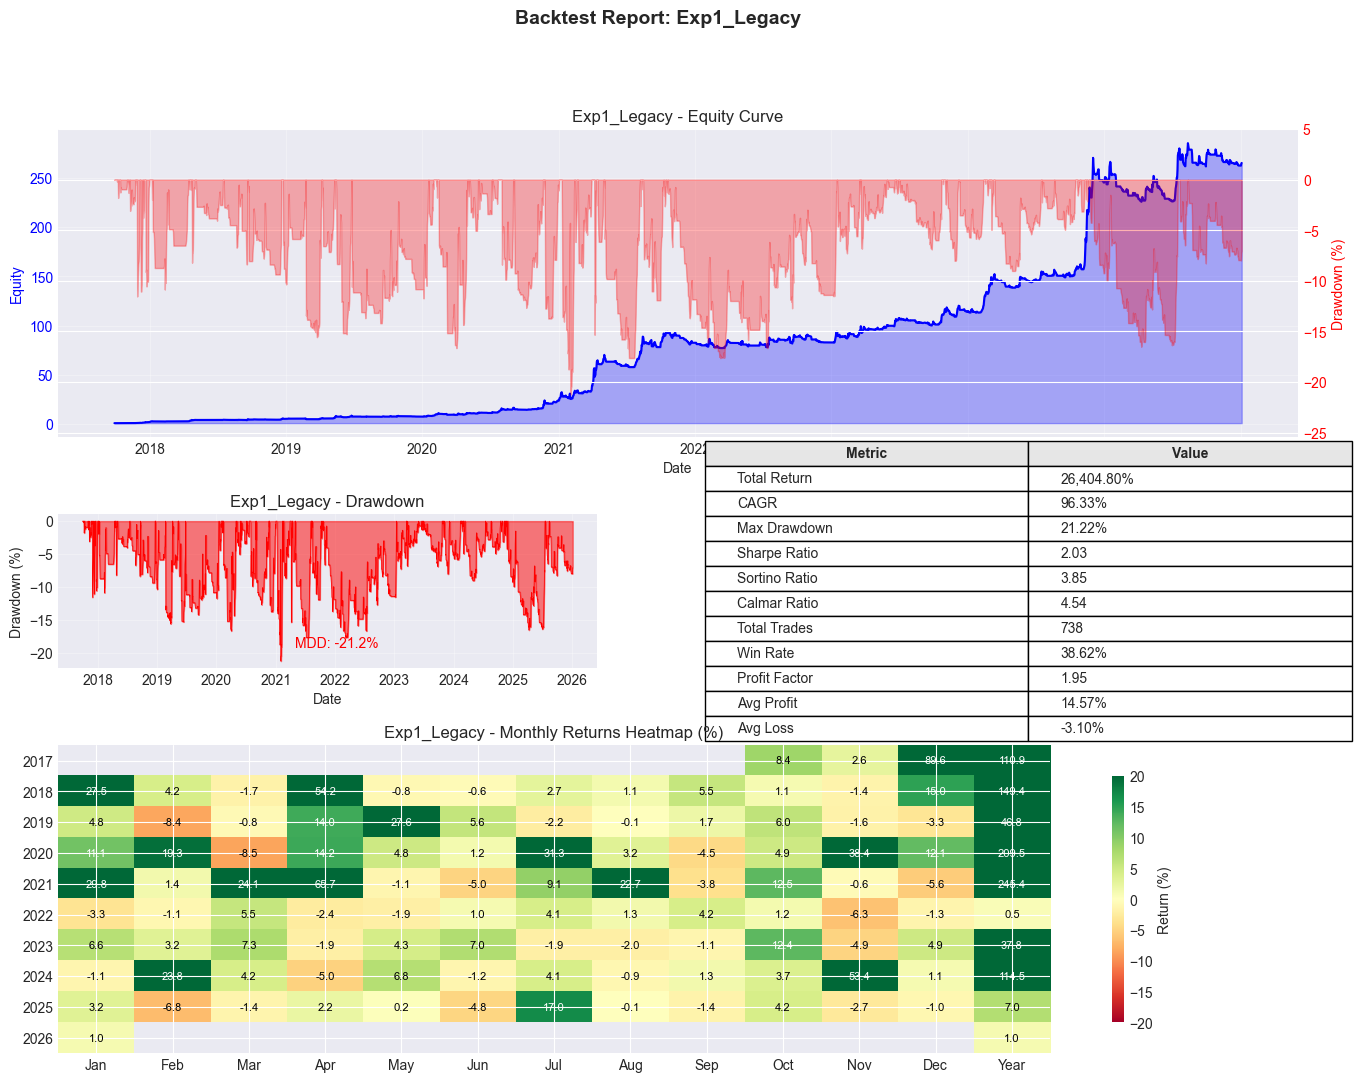


📄 Detailed report saved: C:\workspace\dev\upbit-quant-system\notebooks\experiments\best_strategy_report_Exp1_Legacy.png


In [9]:
# 최적 전략 찾기 (Calmar Ratio 기준)
if not comparison_df.empty:
    best_idx = comparison_df["Calmar"].idxmax()
    best_experiment = comparison_df.iloc[best_idx]

    print("🏆 Best Strategy (by Calmar Ratio)")
    print("=" * 60)
    print(f"Name: {best_experiment['Name']}")
    print(f"CAGR: {best_experiment['CAGR']:.2f}%")
    print(f"MDD: {best_experiment['MDD']:.2f}%")
    print(f"Sharpe: {best_experiment['Sharpe']:.2f}")
    print(f"Calmar: {best_experiment['Calmar']:.2f}")
    print(f"Win Rate: {best_experiment['Win Rate']:.2f}%")
    print(f"Total Trades: {best_experiment['Trades']}")
    print("=" * 60)

    # 최적 전략의 상세 리포트 생성
    best_exp_id = int(best_experiment["ID"])
    best_exp_data = tracker.experiments[best_exp_id - 1]

    # 전략 재생성 및 백테스트
    strategy_params = best_exp_data["strategy_params"]
    if "name" in strategy_params:
        strategy_name = strategy_params.pop("name")
    else:
        strategy_name = best_experiment["Name"]

    # 전략 생성 (파라미터에 따라)
    if "sma_period" in strategy_params:
        strategy = VanillaVBO(name=strategy_name, **strategy_params)
    else:
        strategy = create_vbo_strategy(name=strategy_name, **strategy_params)

    result = run_backtest(
        strategy=strategy,
        tickers=tickers,
        interval="day",
        config=base_config,
    )

    # 상세 리포트 생성
    report_path = experiments_dir / f"best_strategy_report_{best_experiment['Name']}.png"
    generate_report(
        result=result,
        save_path=report_path,
        show=True,
    )

    print(f"\n📄 Detailed report saved: {report_path}")
else:
    print("No experiments to analyze")

## 커스텀 실험

자신만의 전략 파라미터를 실험해보세요. 아래 셀을 수정하여 사용하세요.

In [10]:
# 커스텀 실험 예제
# 아래 파라미터를 수정하여 실험하세요

custom_strategy = VanillaVBO(
    name="CustomExperiment",
    sma_period=4,  # 변경 가능
    trend_sma_period=8,  # 변경 가능
    short_noise_period=4,  # 변경 가능
    long_noise_period=8,  # 변경 가능
)

custom_config = BacktestConfig(
    initial_capital=1.0,
    fee_rate=0.0005,
    slippage_rate=0.0005,
    max_slots=4,  # 변경 가능
)

result = run_backtest(
    strategy=custom_strategy,
    tickers=tickers,
    interval="day",
    config=custom_config,
)

# 결과 저장
tracker.save_experiment(
    name="Custom_Experiment",
    strategy_params={
        "sma_period": custom_strategy.sma_period,
        "trend_sma_period": custom_strategy.trend_sma_period,
        "short_noise_period": custom_strategy.short_noise_period,
        "long_noise_period": custom_strategy.long_noise_period,
    },
    config_params=custom_config.__dict__,
    result=result,
    notes="Custom experiment - modify parameters above",
)

print(result.summary())

💾 Experiment saved: experiment_012_Custom_Experiment.json

Strategy: CustomExperiment
CAGR: 65.23%
MDD: 24.85%
Calmar Ratio: 2.62
Sharpe Ratio: 1.66
Win Rate: 37.59%
Total Trades: 846
Final Equity: 63.7361
